In [12]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen=20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print("Train data shape: {}".format(x_train.shape))
print("Test data shape: {}".format(x_test.shape))

Train data shape: (25000,)
Test data shape: (25000,)


In [13]:
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print("Train data shape: {}".format(x_train.shape))
print("Test data shape: {}".format(x_test.shape))

Train data shape: (25000, 20)
Test data shape: (25000, 20)


In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x_train, y_train, epochs=10,
batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 84us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6810
Epoch 2/10
20000/20000 [==============================] - 1s 55us/step - loss: 0.5658 - acc: 0.7426 - val_loss: 0.5467 - val_acc: 0.7204
Epoch 3/10
20000/20000 [==============================] - 1s 59us/step - loss: 0.4752 - acc: 0.7806 - val_loss: 0.5113 - val_acc: 0.7384
Epoch 4/10
20000/20000 [==============================] - 1s 61us/step - loss: 0.4263 - acc: 0.8077 - val_loss: 0.5008 - val_acc: 0.7452
Epoch 5/10
20000/20000 [==============================] - 1s 56us/step - loss: 0.3930 - acc: 0.8257 - val_loss: 0.4981 - val_acc: 0.7536
Epoch 6/10
20000/20000 [==============================] - 1s 64us/step - loss: 0.3668 - acc: 0.8396 - val_loss: 0.5014 - val_acc: 0.7530
Epoch 7/10
20000/20000 [==============================] - 1s 61us/step - loss: 0.3435 - acc: 0.8533 - val_loss: 0.5052 - val_acc:

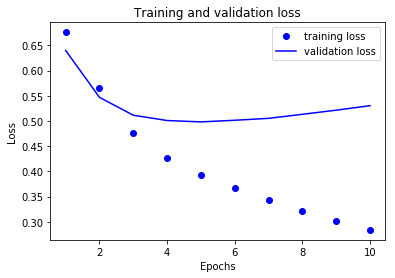

In [18]:
import matplotlib.pyplot as plt 

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

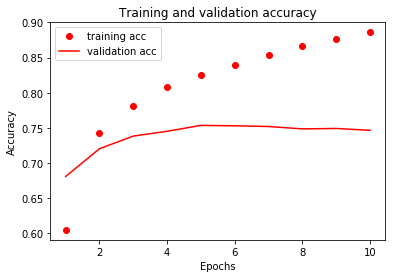

In [19]:
plt.clf()

acc = history.history['acc']
va_acc = history.history['val_acc']

plt.plot(epochs, acc, 'ro', label='training acc')
plt.plot(epochs, va_acc, 'r', label='validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Using pretrained word embeddings

In [25]:
import os

imdb_dir = "/Users/duarteocarmo/Downloads/aclImdb"
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname.endswith('.txt'):
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [27]:
# tokenizing the data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print("Found {} different tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

labels=np.asarray(labels)
print("Shape of data tensor: ", data.shape)
print("Shape of label tensor: ", labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

Found 88582 different tokens.
Shape of data tensor:  (25000, 100)
Shape of label tensor:  (25000,)


In [29]:
# pre processing the embeddings
glove_dir = "/Volumes/DuarteWork/Words/glove.6B"

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors'.format(len(embeddings_index)))

Found 400000 word vectors


In [30]:
# glove embeddings matrx
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Definning a model

In [31]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

## Training the model

In [35]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

history=model.fit(x_train, y_train, 
                  epochs=10, 
                  batch_size=32,
                  validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 1.9450 - acc: 0.5050 - val_loss: 0.6939 - val_acc: 0.5127
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5853 - acc: 0.7000 - val_loss: 0.7965 - val_acc: 0.5117
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5177 - acc: 0.7400 - val_loss: 0.6902 - val_acc: 0.5704
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4070 - acc: 0.8150 - val_loss: 0.9653 - val_acc: 0.4960
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2632 - acc: 0.9000 - val_loss: 1.2120 - val_acc: 0.5156
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3198 - acc: 0.8400 - val_loss: 0.9211 - val_acc: 0.5151
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1168 - acc: 0.9800 - val_loss: 0.7564 - val_acc: 0.5593
Epoch 8/10
200/200 [========

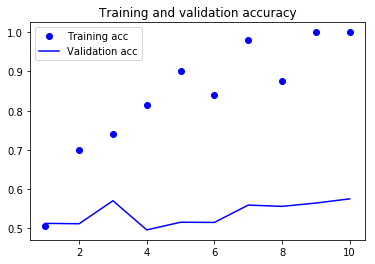

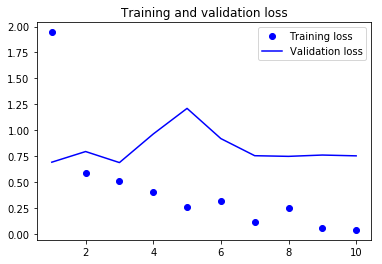

In [36]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## No pretrained word embeddings

In [37]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6941 - acc: 0.5000 - val_loss: 0.6956 - val_acc: 0.5148
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4967 - a

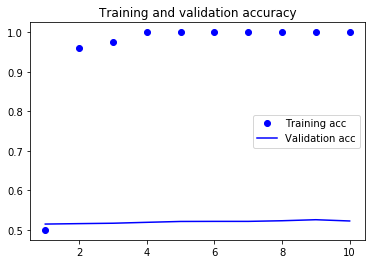

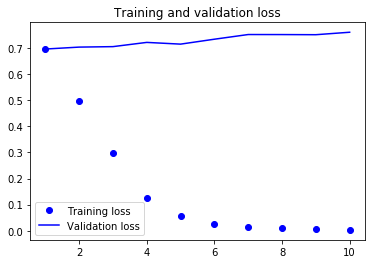

In [38]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [39]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [40]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 58us/step


[0.7645391596221924, 0.56692]